<a href="https://colab.research.google.com/github/SheidaTalei/FinalProject/blob/main/SheidaTalei_Preprocessing_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SUBJECT: Preprocessing 
## Author:  Sheida Talei

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
#Convert a collection of raw documents to a matrix of TF-IDF features.
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import regex
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from hazm import *
import re
import string
import persianutils as pu
import persianutils.PersianAlphabet as pALpha




In [ ]:
!pip install hazm

  Using cached https://files.pythonhosted.org/packages/22/13/5a7074bc11d20dbbb46239349ac3f85f7edc148b4cf68e9b8c2f8263830c/hazm-0.7.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/50/09/3b1755d528ad9156ee7243d52aa5cd2b809ef053a0f31b53d92853dd653a/nltk-3.3.0.zip
  Using cached https://files.pythonhosted.org/packages/bc/0f/1c9b49bb49821b5856a64ea6fac8d96a619b9f291d1f06999ea98a32c89c/libwapiti-0.2.1.tar.gz
  Created wheel for nltk: filename=nltk-3.3-cp36-none-any.whl size=1394468 sha256=c12961a82587dd80fc17f65bb20640dc0bb2c65cf549151e0a5a32044ab5d4da
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp36-cp36m-linux_x86_64.whl size=154228 sha256=970bddf4f1a3c725799cdab58b6d734f0ad52e460d8c812ba0bd6d6c2d35f572
  Stored in directory: /root/.cache/pip/wheels/66/15/54/4510dce8bb958b1cdd2c47425cbd1e1eecc0480ac9bb1fb9ab
Successfully built nltk libwapiti
  Fou

In [ ]:
!pip install persianutils

In [ ]:
#------------------------------------------Empty Rows Removal----------------------------------------------------------------
# This function Will: 1- Remove all empty rows from csv file 2- Save data to the same csv
def removeEmptyRows(fileName):
    df = pd.read_csv(fileName, encoding='utf-8-sig')
    df = df.dropna(subset=['text'], how='all', axis=0) 
    df.to_csv(fileName, header=True, encoding='utf-8-sig',  index=False)
    
    return df

In [ ]:
#------------------------------------------------Normalization---------------------------------------------------------------
# This function will: 1- Normalize tweets (replace space with half-space)
def normalization (content):
    normalizer = Normalizer()
    tweets_normalize_list = []
    temp_set = []
    for item in range (len(content)):
        for word in content[item]:
            temp_word = normalizer.normalize(word)
            temp_set.append(temp_word.replace('\u200c', ' ', 1000000000))
                
                
        tweets_normalize_list.append(set(temp_set))
        temp_set = []
        
    return tweets_normalize_list

In [ ]:
#---------------------------------------------------- Latin and Punctuation Removal-------------------------------------------
# This function will: 1- Remove latin words 2- Remove punctuations
# Source: https://stackoverflow.com/questions/18429143/strip-punctuation-with-regex-python/50985687
def latinRemoval(content):
    only_persian_tweet_list =[]
    temp_set = []

    latin = re.compile(r'[a-zA-Z0-9@$!%*?&-_`.+#(»)«,:;،؛…..؟]+')  

    for item in range(len(content)):
        for word in content[item]:
            temp_word = word.replace('\u200c', ' ', 1000000000)
               
            if not(latin.match(temp_word)) :
                if not temp_word.isdigit():
                        #source: https://pypi.org/project/persianutils/
                    word = re.findall(r'[^۰-۹]+', temp_word.strip(string.punctuation))
                    
                    if len(word) >0:    
                        processed_text = pu.standardize4Word2vec(word[0].strip())

                        if (processed_text != ' '):
#                             print(processed_text)
                            word = re.findall('\d+', processed_text.strip())
                            if len(word)==0 : 
                                temp_set.append(processed_text.strip())
                                print (processed_text.strip())
           
        only_persian_tweet_list.append(set(temp_set))
        temp_set = []
        
    return only_persian_tweet_list

In [ ]:
#--------------------------------------------------Loading StopWords ------------------------------------------
#Source of file: https://sites.google.com/site/kevinbouge/stopwords-lists
def getStopWord ():
    try:
        file = open('/content/drive/MyDrive/Final/stopwords_fa.txt', 'r', encoding='utf-8-sig')
        file_readed = file.read()
    
    finally:
        file.close()
        
    stopWord_Set = set(file_readed.split())
    return stopWord_Set


In [ ]:
#------------------------------------Tokenization and Stop Word Removal------------------------------------------------------
# This function will: 1- Tokenize words  2- Remove stop words and return a list of sets
def getTweetNoStopWord(content):
    tweet_no_StopWord_list =[]
    temp_set = []
    stop_word_list = getStopWord()
    for item in range(len(content)):
        for word in content[item]:
            if not word in stop_word_list:
                temp_set.append(word.replace('\u200c', ' ', 1000000000))
                
        tweet_no_StopWord_list.append(set (temp_set))
        temp_set = []
        
    return tweet_no_StopWord_list

In [ ]:
#----------------------------------------------Lemmatization ------------------------------------------------------------------
def Lemmatization (content):
    lemmatizer = Lemmatizer()
    tweets_lemmatize_list = []
    temp_set = []
    for item in range(len(content)):
        for word in (content[item]):
            temp_set.append(lemmatizer.lemmatize(word.replace('\u200c', ' ', 1000000000)))
        tweets_lemmatize_list.append(set(temp_set))
        temp_set = []
    
    return tweets_lemmatize_list

In [ ]:
#---------------------------------------------------Tokenization-------------------------------------------------------------
# Tokenizing X and at the end append Y as a label
def tokenization (X):
    tokenized_train_data = []
    for item in range(len(X)):
        var = word_tokenize(X[item])
#         var.append(Y[item])
        tokenized_train_data.append(var)
        
    return tokenized_train_data    

In [ ]:
#Loading data
df1 =  pd.read_csv ('/content/drive/MyDrive/Final/Main#1.csv', encoding='utf-8-sig')
df2 = pd.read_csv ('/content/drive/MyDrive/Final/Main#2.csv', encoding='utf-8-sig')
df3 = pd.read_csv ('/content/drive/MyDrive/Final/Main#3.csv', encoding='utf-8-sig')
df4 = pd.read_csv ('/content/drive/MyDrive/Final/Main#4.csv', encoding='utf-8-sig')
df5 = pd.read_csv ('/content/drive/MyDrive/Final/Main#5.csv', encoding='utf-8-sig')


data_frame= pd.concat([df1, df2, df3, df4, df5], ignore_index=True)


In [ ]:
#----------------------------------------------------------Step1----------------------------------------------------------
#----------------------------------Normalization_StopWord_Lemmatization_Punctuaation--------------------------------------
#Reading just coulmns of description and Label
# Remove repetetive tweets
def cleanData (df):
    df.drop_duplicates(subset=['text', 'tweeter_handle'], inplace=True)
    train_data, test_data = train_test_split(df, test_size=0.2)
    print('train data size: {}    test data size: {}'.format(len(train_data), len(test_data)))
    train_data.to_csv('/content/drive/MyDrive/Final/X_and_Y.csv', index=False, encoding='utf-8-sig')
    


    #Step 1: Removing empty rows from data set which contains only description and Label
    # This functon will remove empty rows and save them to same file (input file)
    removeEmptyRows('/content/drive/MyDrive/Final/X_and_Y.csv')
    
    #test
    test_data.to_csv('/content/drive/MyDrive/Final/X_and_Y_test.csv', index=False, encoding='utf-8-sig')
    #Step 1: Removing empty rows from data set which contains only description and Label
    # This functon will remove empty rows and save them to same file (input file)
    removeEmptyRows('/content/drive/MyDrive/Final/X_and_Y_test.csv')
    
    return df

#---------------------------------------------test-------------------------------------------------------------------------



In [ ]:
cleanData (data_frame)


train data size: 30282    test data size: 7571


,id,text,Label,url,description,followers_count,friends_count,listed_count,favourites_count,statues_count,expanded_URL,tweeter_handle
0,1.318144e+18,RT @begoonaah: کلکسیونی از افتخارات ورزشی شهید...,0.0,NaN,‏‏‏‏‏‏‏‏‏‏‏نه به دیکتاتوری،چه شاه، چه شیخ.\nدر...,138.0,33.0,0.0,19978.0,20692.0,NaN,erschadi
1,1.318144e+18,تو بگو \n#قاچاق_دارو کار ما نبوده\n#انسولین_نی...,0.0,https://t.co/v3zSQ1kKPJ,‏‏‏‎‎‎#براندازم \nانفالو یاب ندارم شما رو به و...,1273.0,1280.0,0.0,10104.0,11023.0,https://twitter.com/i/web/status/1318095448977...,Pari7322
2,1.318144e+18,😭😭😭😭لعنت به جمهوری اسلامی مرگ بر سپاه پاسداران...,1.0,https://t.co/K3DN6lLUCU,NaN,141.0,170.0,0.0,16803.0,4166.0,https://twitter.com/i/web/status/1318072174033...,Korosh87420941
3,1.318144e+18,به این ویدیو نگاه کنید،این سرباز جنگی و در خط ...,0.0,https://t.co/hxGLTrQPyQ,🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩⬜⬜⬜⬜⬜⬜⬜⬜🌞🦁⬜⬜⬜⬜⬜⬜⬜⬜⬜🟥🟥🟥🟥🟥🟥🟥🟥...,862.0,1021.0,0.0,11546.0,4656.0,https://twitter.com/i/web/status/1317981205850...,amirggh12
4,1.318145e+18,🎋 #ایران -فراخوان مراسم بزرگداشت چهلمین روز شه...,0.0,https://t.co/4EjQ29hkGQ,‏‏‏‏‏‏‏‏‏‏‏نه به دیکتاتوری،چه شاه، چه شیخ.\nدر...,138.0,33.0,0.0,19984.0,20698.0,https://twitter.com/i/web/status/1318144154153...,erschadi
...,...,...,...,...,...,...,...,...,...,...,...,...
48029,1.319322e+18,RT @tanasoli: با دوچرخه از روی اصلاحات رد شد!,0.0,NaN,‏‏‏👑🦁🌞\n‏خسته از بودن .\nبودن یا نبودن؟,1457.0,1503.0,0.0,17155.0,9422.0,NaN,Mohiman1360
48030,1.319322e+18,آخرهفته هم باگاف ضدانقلاب تمام شد. دعوای شخصی ...,0.0,https://t.co/QEj7M6oyjr,‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏🏞‏‏‏‏‏‏‏‏‏‏‏...,5614.0,5072.0,1.0,26522.0,11944.0,https://twitter.com/i/web/status/1319317306732...,zhrwlii17
48031,1.319322e+18,#مهدی_کاظمی مامور حراست پالایشگاه و #احمد_جهان...,1.0,https://t.co/OwLyM31G08,NaN,498.0,483.0,0.0,10264.0,3474.0,https://twitter.com/i/web/status/1319296469522...,dilani64
48032,1.319322e+18,RT @tiredzra: ما همه صدای #دختر_آبادانی هستیم:...,0.0,NaN,‏‏‏‏‏Larrie / Ziam child\n~INFP ~ 🏳️‍🌈 TPWK ~ ...,512.0,392.0,1.0,20687.0,7314.0,NaN,smiley_niyaz


In [ ]:
#------------------------------------------------------Step 2------------------------------------------------------------------
#step 2: Tokenizing data
X_and_Y = pd.read_csv('/content/drive/MyDrive/Final/X_and_Y.csv',encoding="utf-8")



X_train = X_and_Y.text
Y_train= X_and_Y.Label


#Tokenization
train_data_tokenize_list = tokenization (X_train)
#------------------------------------------------------test---------------------------------------------------------------------
#step 2: Tokenizing data
X_and_Y_test = pd.read_csv('/content/drive/MyDrive/Final/X_and_Y_test.csv',encoding="utf-8")



X_test = X_and_Y_test.text
Y_test= X_and_Y_test.Label

# #Tokenization
train_data_tokenize_list_test = tokenization (X_test)

In [ ]:
print(train_data_tokenize_list[3755])

['ملتو', 'سر', 'کار', 'گذاشتن', 'با', 'این', 'دلار', 'خداییش']


In [ ]:
#------------------------------------------------------Step 3------------------------------------------------------------------
#step 3: removing HASHTAGS, MENTIONS, NUMBERS and any LATIN WORD
# This function get tokenized list of data and remove mentioned elements

only_persian_tweet_list = latinRemoval(train_data_tokenize_list)
#------------------------------------------------------test--------------------------------------------------------------------
#step 3: removing HASHTAGS, MENTIONS, NUMBERS and any LATIN WORD
# This function get tokenized list of data and remove mentioned elements

only_persian_tweet_list_test = latinRemoval(train_data_tokenize_list_test)

Streaming output truncated to the last 5000 lines.
اگر
دیوار…
اقازاده
های
اصولگرا
کثیف
تر
از
اقازاده
های
اصلاح
طلبن
پدر
اینا
ادعای
انقلابی
داره
و
مرگ
بر
امریکا
میگه
م…
بچه
ها
لانتوس
نیاز
دارم
لطفا
اگه
کسی
میتونه
کمک
کنه
خبر
بده
کاش
اون
پلیسها
و
غیره
بزرگوار
و
وظیفه
شناس
و
سریع
العمل
و
خدوم
و
با
هوش
و
غیره
ای
که
اون
خانم
بی
حجاب
دوچرخه
سوار
در
نجف
اباد
اصفهان
را
دستگیر
کردن
مسئول
رسیدگی
و
برخورد
اینچنین
با
قاچاق
دارو
و
نبود
انسولین
و
پیگرد
اون
عده
بسیییییاااااااار
قلیل
مفسدان
اقتصادی
و
غیره
میکردن
کاش
ساکت
نمونید
ساکت
نمونید
ساکت
نمونید
ساکت
نمونید
ساکت
نمونید
ساکت
نمونید
ساکت
نمونید
ساکت
نمونید
بفرما
دیدی
هم
کار
خودشونه
پیامدهای
سقوط
شاخص
اینکه
یعنی
برای
همه
نیست
اما
مدیر
روابط عمومی
گفته است
با
کارت
ملی
داده می شود
سوال
ما
این
است
تکلیف
کودکان
بدون
مدارک
هویتی
چه
می شود
⭕   ترامپ
رای
بیاورد
خاورمیانه
را
برای
سال
تغییر
می دهیم
دیوید
فریدمن
سفیر
امریکا
در
اسرائیل
گفته
اگر
دونالد
ترامپ
رئیس جمهور
امریکا
برای
یک
دور
دیگر
انتخاب
شود
واشنگتن
خاورمیانه
را
برای
سال
بعد
تغییر
خواهد داد
زندگی
ز

In [ ]:
print(train_data_tokenize_list[3755])
print ('  ')
print(only_persian_tweet_list[3755])

['ملتو', 'سر', 'کار', 'گذاشتن', 'با', 'این', 'دلار', 'خداییش']
  
{'کار', 'این', 'گذاشتن', 'دلار', 'خداییش', 'سر', 'با', 'ملتو'}


In [ ]:
#------------------------------------------------------Step 4------------------------------------------------------------------
#step 4: Normalization
normalize_tweet_list = normalization (only_persian_tweet_list)

#-------------------------------------------------------test-------------------------------------------------------------------
#step 4: Normalization
normalize_tweet_list_test = normalization (only_persian_tweet_list_test)


In [ ]:
print(normalize_tweet_list[3755])

{'کار', 'دلار', 'این', 'گذاشتن', 'خداییش', 'سر', 'با', 'ملتو'}


In [ ]:
#------------------------------------------------------Step 5------------------------------------------------------------------
#step 5: Remove stop words
noStopWord_tweet_List = getTweetNoStopWord(normalize_tweet_list)

#-------------------------------------------------------test-------------------------------------------------------------------
#step 5: Remove stop words
noStopWord_tweet_List_test = getTweetNoStopWord(normalize_tweet_list_test)


In [ ]:
print(noStopWord_tweet_List[3755])

{'کار', 'دلار', 'گذاشتن', 'خداییش', 'سر', 'ملتو'}


In [ ]:
#------------------------------------------------------Step 6------------------------------------------------------------------
#step 6: Lemmatixation
lemmatize_tweet_list = Lemmatization (noStopWord_tweet_List)
#-------------------------------------------------------test-------------------------------------------------------------------
#step 6: Lemmatixation
lemmatize_tweet_list_test = Lemmatization (noStopWord_tweet_List_test)


In [ ]:
print(lemmatize_tweet_list[6699])

{'خواهند سرمایه', 'رانت', 'بازار', 'ماه', 'مثبت', 'فرصت', 'مهر', 'کرد#کن', 'چهارشنبه', 'صعود', 'دستور', 'خارج', 'بهترین', 'کسانی'}


train data size: 30282    test data size: 7571


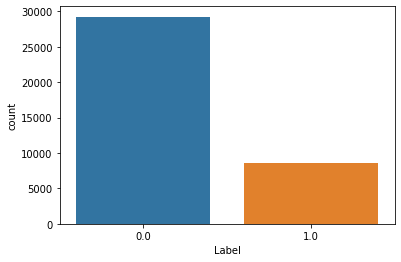

In [ ]:
#Source : https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/
#shows the proportion of the whole data both train and test
import seaborn as sns

sns.countplot(x='Label', data=cleanData (data_frame))

In [ ]:
def convertSequenceWordsToText(input_list,  fileName, lastFileName):
    X_and_Y = pd.read_csv(fileName , encoding="utf-8")
    text = ''
    counter = 0
    for item in input_list:
        for i in range(len(item)):
            text += list(item)[i] + ' '
        print(counter)    
        X_and_Y.loc [counter, 'text'] = text.strip()
        X_and_Y.to_csv(lastFileName ,index=False, encoding='utf-8-sig')
        counter = counter + 1
        text =''

In [ ]:

convertSequenceWordsToText(lemmatize_tweet_list, '/content/drive/MyDrive/Final/X_and_Y.csv', '/content/drive/MyDrive/Final/Prepared_train_Data.csv')

Streaming output truncated to the last 5000 lines.
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
25333
25334
25335
25336
25337
25338
25339
25340
25341
25342
25343
25344
25345
25346
25347
25348
25349
25350
25351
25352
25353
25354
25355
25356
25357
25358
25359
25360
25361
25362
25363
25364
25365
25366
25367
25368
25369
25370
25371
25372
25373
25374
25375
25376
25377
25378
25379
25380
25381
25382
25383
25384
25385
25386
25387
25388
25389
25390
25391
25392
25393
25394
25395
25396
25397
25398
25399
25400
25401
25402
25403
25404
25405
25406
25407
25408
25409
25410
25411
25412
25413
25414
25415
25416
25417
25418
25419
25420
25421
25422
25423
25424
25425
25426
25427
25428
25429
25430
25431
25432
25433
25434
25435
25436
25437
25438
2

In [ ]:
convertSequenceWordsToText(lemmatize_tweet_list_test, '/content/drive/MyDrive/Final/X_and_Y_test.csv', '/content/drive/MyDrive/Final/Prepared_test_Data.csv' )

Streaming output truncated to the last 5000 lines.
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760